In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as l
from tensorflow.keras.datasets import mnist
from tensorflow.data import Dataset
from tensorflow.keras.regularizers import l2


In [18]:
(x_train, y_train), (_, _) = mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1).astype(np.float32)
x_train = (x_train - 127.5) / 127.5  # Normalize to [-1, 1]
y_train = y_train.reshape(-1, 1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [76]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
NUM_CLASSES = 10
NOISE_DIM = 100
EPOCHS = 10

In [20]:
dataset = Dataset.from_tensor_slices((x_train,y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [70]:
def build_generator():
    noise_input = l.Input(shape=(NOISE_DIM,))
    label_input = l.Input(shape=(1,), dtype=tf.int32)

    label_embedding = l.Embedding(NUM_CLASSES, NOISE_DIM)(label_input)
    label_embedding = l.Reshape((NOISE_DIM,))(label_embedding)  # Ensure correct shape

    combined_input = l.Multiply()([ , label_embedding])

    x = l.Dense(7 * 7 * 128, use_bias=False)(combined_input)
    x = l.BatchNormalization()(x)
    x = l.LeakyReLU()(x)
    x = l.Reshape((7, 7, 128))(x)

    x = l.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False)(x)
    x = l.BatchNormalization()(x)
    x = l.LeakyReLU()(x)

    x = l.Conv2DTranspose(1, (4, 4), strides=(2, 2), padding='same', activation='tanh')(x)

    return tf.keras.Model([noise_input, label_input], x)


In [71]:
generator = build_generator()

In [72]:
generator.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_13 (Embedding)  │ (None, 1, 100)         │          1,000 │ input_layer_27[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_26            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_19 (Reshape)      │ (None, 100)            │              0 │ embedding_13[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_8 (Multiply)     │ (None, 100)            │              0 │ input_layer_26[0][0],  │
│                           │                        │                │ reshape_19[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 6272)           │        627,200 │ multiply_8[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 6272)           │         25,088 │ dense_11[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_24            │ (None, 6272)           │              0 │ batch_normalization_2… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_20 (Reshape)      │ (None, 7, 7, 128)      │              0 │ leaky_re_lu_24[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_20       │ (None, 14, 14, 64)     │        131,072 │ reshape_20[0][0]       │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 14, 14, 64)     │            256 │ conv2d_transpose_20[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_25            │ (None, 14, 14, 64)     │              0 │ batch_normalization_2… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_21       │ (None, 28, 28, 1)      │          1,025 │ leaky_re_lu_25[0][0]   │
│ (Conv2DTranspose)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 785,641 (3.00 MB)

 Trainable params: 772,969 (2.95 MB)

 Non-trainable params: 12,672 (49.50 KB)

In [26]:
def build_discriminator():
  image_input = l.Input(shape=(28,28,1))
  label_input = l.Input(shape=(1,), dtype=tf.int32)
  label_embeddings = l.Embedding(NUM_CLASSES , 28 * 28 * 1)(label_input)
  label_reshaped = l.Reshape((28,28,1))(label_embeddings)

  x = l.Concatenate()([image_input, label_reshaped])
  x = l.Con4v2D(64, (4,4), strides=(2,2), padding='same')(x)
  x = l.LeakyReLU()(x)
  x = l.Conv2D(128, (4,4), strides=(2,2), padding='same')(x)
  x = l.LeakyReLU()(x)
  x = l.Flatten()(x)
  x = l.Dense(1 , activation = "sigmoid")(x)

  return keras.Model([image_input, label_input], x)

In [27]:
discriminator = build_discriminator()

In [28]:
discriminator.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 1, 784)         │          7,840 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_8             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 28, 28, 1)      │              0 │ embedding_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 28, 28, 2)      │              0 │ input_layer_8[0][0],   │
│ (Concatenate)             │                        │                │ reshape_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 14, 14, 64)     │          2,112 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_7 (LeakyReLU) │ (None, 14, 14, 64)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 7, 7, 128)      │        131,200 │ leaky_re_lu_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_8 (LeakyReLU) │ (None, 7, 7, 128)      │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 6272)           │              0 │ leaky_re_lu_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │          6,273 │ flatten_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 147,425 (575.88 KB)

 Trainable params: 147,425 (575.88 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
loss_function = keras.losses.BinaryCrossentropy()
g_opt = keras.optimizers.Adam(learning_rate=0.0001)
d_opt = keras.optimizers.Adam(learning_rate=0.0001)

In [77]:
def train_step(images, labels):
  batch_size = tf.shape(images)[0]  # Get actual batch size

  noise = tf.random.normal([batch_size, NOISE_DIM])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator([noise, labels], training=True)
    real_output = discriminator([images, labels], training=True)
    fake_output = discriminator([generated_images, labels], training=True)

    d_loss = loss_function(tf.ones_like(real_output), real_output) + loss_function(tf.zeros_like(fake_output), fake_output)
    g_loss = loss_function(tf.ones_like(fake_output), fake_output)

  d_grad = disc_tape.gradient(d_loss, discriminator.trainable_variables)
  g_grad = gen_tape.gradient(g_loss, generator.trainable_variables)
  d_opt.apply_gradients(zip(d_grad, discriminator.trainable_variables))
  g_opt.apply_gradients(zip(g_grad, generator.trainable_variables))

  return d_loss, g_loss

In [80]:
def train(dataset, epochs):
    for epoch in range(epochs):
        epoch_d_loss, epoch_g_loss = 0, 0
        num_batches = 0
        for images, labels in dataset:
            d_loss, g_loss = train_step(images, labels)
            epoch_d_loss += d_loss.numpy()
            epoch_g_loss += g_loss.numpy()
            num_batches += 1

        epoch_d_loss /= num_batches
        epoch_g_loss /= num_batches
        print(f'Epoch {epoch+1}/{epochs} ====== D Loss: {epoch_d_loss:.4f}, G Loss: {epoch_g_loss:.4f}')
        if (epoch + 1) % 10 == 0:
            generate_and_save_images(epoch + 1)

    generator.save("generator_model.h5")
    discriminator.save("discriminator_model.h5")
    print("✅ Models saved successfully!")

In [32]:
def generate_and_save_images(epoch):
  noise = tf.random.normal([NUM_CLASSES, NOISE_DIM])
  labels = tf.range(NUM_CLASSES , dtype = tf.int32)
  generated_images = generator.predict([noise, labels])
  generated_images = (generated_images + 1)/2.0

  fig , axes = plt.subplots(1, NUM_CLASSES, figsize = (10,10))
  for i , ax in enumerate(axes):
    ax.imshow(generated_images[i])
    ax.set_title(f'Class {i}')
    ax.axis('off')


  plt.savefig(f'generated_images_epoch_{epoch}.png')
  plt.show()


Epoch 1/10 ====== D Loss: 1.2847, G Loss: 0.8298
Epoch 2/10 ====== D Loss: 1.2881, G Loss: 0.8170
Epoch 3/10 ====== D Loss: 1.2895, G Loss: 0.8201
Epoch 4/10 ====== D Loss: 1.2702, G Loss: 0.8249
Epoch 5/10 ====== D Loss: 1.2628, G Loss: 0.8422
Epoch 6/10 ====== D Loss: 1.2672, G Loss: 0.8414
Epoch 7/10 ====== D Loss: 1.2647, G Loss: 0.8347
Epoch 8/10 ====== D Loss: 1.2665, G Loss: 0.8259
Epoch 9/10 ====== D Loss: 1.2704, G Loss: 0.8164
Epoch 10/10 ====== D Loss: 1.2663, G Loss: 0.8258
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


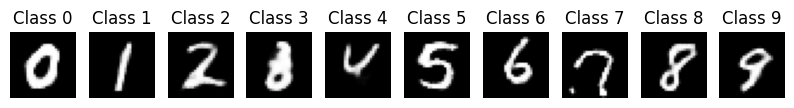

✅ Models saved successfully!


In [84]:
train(dataset , EPOCHS)